In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

bufferdensity maps of tweets??

In [2]:
import os
import io
import pickle
import re
import json
import gzip
import cProfile
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import ray
import numpy as np
import geopandas as geopd
import pandas as pd
import src.data.access as data_access
import src.utils.files as file_utils
import src.utils.geometry as geo
import src.utils.places_to_cells as places_to_cells
import src.utils.parallel as parallel
import src.data.text_process as text_process
import src.data.word_counts as word_counts
import src.data.clustering as data_clustering
from dotenv import load_dotenv
import libpysal
import esda
load_dotenv()

True

Large todo: US, IN, CA

# Config

In [19]:
num_cpus = 8
latlon_proj = 'epsg:4326'
source_files_format = '{kind}_{from}_{to}_{cc}.json.gz'
source_data_path = Path(os.environ['DATA_DIR'])
proj_data_path = Path(os.environ['PWD']) / 'data'
ext_data_path = proj_data_path / 'external'
with open(ext_data_path / 'countries.json') as f:
    countries_dict = json.load(f)
lang = 'en'
cc = 'AU'
reg_dict = countries_dict[cc] 
xy_proj = reg_dict['xy_proj']
min_nr_cells = 3
cell_tokens_decade_crit = 2
upper_th = 0.8
max_place_area = reg_dict.get('max_place_area', 5e9)
fname_fmt = f'{{}}_lang={lang}_cc={cc}.parquet'

In [20]:
params_dict = {'cc': cc, 'kind': 'tweets'}
source_path_fmt = source_data_path / source_files_format
format_dicts = [{**params_dict, **{'from': m.group('from'), 'to': m.group('to')}}
                for m in file_utils.yield_paramed_matches(source_path_fmt, params_dict)]
tweets_files_paths = [
    Path(str(source_path_fmt).format(**f_dict))
    for f_dict in format_dicts]
places_files_paths = [
    Path(str(source_path_fmt).format(**{**f_dict, **{'kind': 'places'}}))
    for f_dict in format_dicts]

In [21]:
shapefile_dict = {**{'file': 'CNTR_RG_01M_2016_4326.shp', 'col': 'FID', 'val': cc, 'cc': cc},
                  **reg_dict.get('shapefile_dict', {})}
all_cntr_shape_df = geopd.read_file(ext_data_path / shapefile_dict['file'] / shapefile_dict['file'])
shape_df = geo.extract_shape(all_cntr_shape_df, shapefile_dict, xy_proj=xy_proj, simplify_tol=100, bbox=reg_dict.get('bbox'))

<AxesSubplot:>

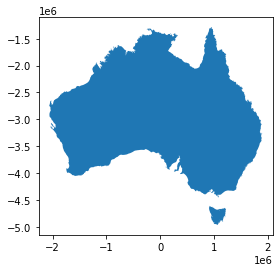

In [22]:
shape_df.plot()

In [173]:
all_cc = set()
for f in source_path_fmt.parent.iterdir():
    regex = source_path_fmt.name.format(**{'kind': 'tweets', 'from': '[0-9]{4}', 'to': '[0-9]{4}', 'cc': '([A-Z]{2})'})
    new_cc = re.match(regex, f.name)
    if new_cc:
        all_cc.add(new_cc.groups()[0])
mask = all_cntr_shape_df['FID'].isin(all_cc)
dict(zip(all_cntr_shape_df.loc[mask, 'FID'], all_cntr_shape_df.loc[mask, 'NAME_ENGL']))

{'AO': 'Angola',
 'AG': 'Antigua and Barbuda',
 'AU': 'Australia',
 'BE': 'Belgium',
 'BO': 'Bolivia',
 'BR': 'Brazil',
 'BZ': 'Belize',
 'CA': 'Canada',
 'CG': 'Congo',
 'CH': 'Switzerland',
 'CL': 'Chile',
 'CR': 'Costa Rica',
 'CO': 'Colombia',
 'CM': 'Cameroon',
 'ES': 'Spain',
 'DO': 'Dominican Republic',
 'DZ': 'Algeria',
 'EC': 'Ecuador',
 'EE': 'Estonia',
 'CU': 'Cuba',
 'EG': 'Egypt',
 'CV': 'Cape Verde',
 'CY': 'Cyprus',
 'FR': 'France',
 'FI': 'Finland',
 'HK': 'Hong Kong',
 'HN': 'Honduras',
 'GQ': 'Equatorial Guinea',
 'GT': 'Guatemala',
 'HT': 'Haiti',
 'GW': 'Guinea-Bissau',
 'ID': 'Indonesia',
 'IE': 'Ireland',
 'IN': 'India',
 'IL': 'Israel',
 'LB': 'Lebanon',
 'LT': 'Lithuania',
 'JM': 'Jamaica',
 'LU': 'Luxembourg',
 'LV': 'Latvia',
 'MX': 'Mexico',
 'MY': 'Malaysia',
 'MG': 'Madagascar',
 'NG': 'Nigeria',
 'NI': 'Nicaragua',
 'MA': 'Morocco',
 'MZ': 'Mozambique',
 'PA': 'Panama',
 'PE': 'Peru',
 'PF': 'French Polynesia',
 'PG': 'Papua New Guinea',
 'PK': 'Pakistan',

In [23]:
places_geodf = data_access.return_json(places_files_paths[1])
places_geodf = geo.make_places_geodf(places_geodf, shape_df, xy_proj=xy_proj)

/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


reminder: newly created GB cells geodf has GB index prefix, whereas previous data has UK prefix

In [24]:
places_geodf.sort_values(by='area').tail(10)

,full_name,url,country,place_type,country_code,attributes,name,min_lon,min_lat,max_lon,max_lat,geometry,area
place_id,,,,,,,,,,,,,
3b108151b4b63172,"Western, South Australia",https://api.twitter.com/1.1/geo/id/3b108151b4b...,Australia,neighborhood,AU,{},Western,129.001395,-31.531113,134.334499,-28.069041,"POLYGON ((-470181.987 -3566677.427, -485274.26...",1.932365e+11
2e8715513e2c08c4,"Telfer, Western Australia",https://api.twitter.com/1.1/geo/id/2e8715513e2...,Australia,neighborhood,AU,{},Telfer,120.064126,-23.509757,126.001296,-19.500000,"POLYGON ((-1405747.433 -2756634.982, -1454516....",2.658287e+11
0ec0c4fcacbd0083,"Victoria, Australia",https://api.twitter.com/1.1/geo/id/0ec0c4fcacb...,Australia,admin,AU,{},Victoria,140.961682,-39.159190,149.976679,-33.980426,"POLYGON ((607857.828 -4419679.869, 639742.611 ...",3.836092e+11
13ff7232c64937bc,"Outback, South Australia",https://api.twitter.com/1.1/geo/id/13ff7232c64...,Australia,neighborhood,AU,{},Outback,132.998100,-32.911981,141.000705,-25.996168,"POLYGON ((-93054.544 -3709556.030, -99099.775 ...",5.727223e+11
4e3c0a60cb10372a,"South Australia, Australia",https://api.twitter.com/1.1/geo/id/4e3c0a60cb1...,Australia,admin,AU,{},South Australia,129.001337,-38.062603,141.002956,-25.996146,"POLYGON ((-441447.773 -4288839.738, -494301.93...",9.510778e+11
265b933184e2b88a,"New South Wales, Australia",https://api.twitter.com/1.1/geo/id/265b933184e...,Australia,admin,AU,{},New South Wales,140.999475,-37.505060,159.109219,-28.157020,"POLYGON ((621453.474 -4235139.336, 678814.256 ...",1.027845e+12
06883f205e78b159,"Northern Territory, Australia",https://api.twitter.com/1.1/geo/id/06883f205e7...,Australia,admin,AU,{},Northern Territory,129.000440,-25.999482,138.001198,-10.965914,"POLYGON ((-494376.070 -2961103.844, -560660.79...",1.337829e+12
7e347291be7bbab4,"Queensland, Australia",https://api.twitter.com/1.1/geo/id/7e347291be7...,Australia,admin,AU,{},Queensland,137.995957,-29.177898,153.552171,-9.142176,"POLYGON ((384111.681 -3305325.207, 454768.198 ...",1.869363e+12
1b66f15d4efa136f,"Western Australia, Australia",https://api.twitter.com/1.1/geo/id/1b66f15d4ef...,Australia,admin,AU,{},Western Australia,112.921114,-35.134846,129.001930,-13.689492,"POLYGON ((-1907657.170 -4114915.124, -2302070....",2.483069e+12


(1490, 2)


<AxesSubplot:>

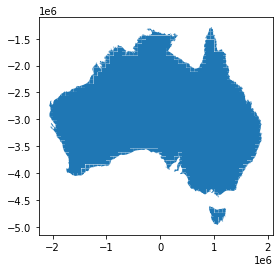

In [25]:
cell_size = reg_dict.get('cell_size', 50e3)
_, cells_geodf, _, _ = geo.create_grid(shape_df, cell_size, xy_proj=xy_proj, intersect=True)
print(cells_geodf.shape)
cells_geodf.plot()

In [26]:
for i, df_access in enumerate(data_access.yield_tweets_access(tweets_files_paths[1], size=1e9)):
    df = data_access.read_json_wrapper(df_access)
    break

In [27]:
df.shape

(842434, 12)

In [28]:
df.join(places_geodf.loc[places_geodf['area'] < 1e10], on='place_id', how='inner').shape

(795537, 25)

<AxesSubplot:>

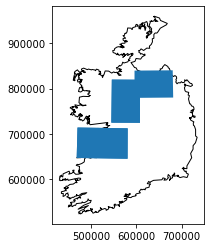

In [44]:
fig, ax = plt.subplots(1)
shape_df.plot(ax=ax, color='none', edgecolor='black')
places_in_xy.loc[(places_in_xy['area'] < 1e10) & (places_in_xy['area'] > 5e9)].plot(ax=ax)

# Process tweets

In [29]:
@ray.remote
def remote_chunk_process(df_access, cells_geodf, places_geodf, cells_in_places, lang):
    cols = ['text', 'source', 'coordinates', 'lang', 'place_id', 'uid']
    tweets_df = data_access.read_json_wrapper(df_access)[cols]
    cell_counts = word_counts.get_cell_word_counts(tweets_df, cells_geodf, places_geodf,
                                                   cells_in_places, lang)
    print('done')
    return cell_counts

prepare places_geodf when larger

In [30]:
ray.init(num_cpus=num_cpus)
cell_counts_refs = []
raw_cell_counts_ref = []
for tweets_fpath, places_fpath in zip(tweets_files_paths, places_files_paths):
    print(tweets_fpath)
    places_geodf = data_access.return_json(places_fpath)
    places_geodf = geo.make_places_geodf(places_geodf, shape_df, xy_proj=xy_proj)
    max_area_mask = places_geodf['area'] < max_place_area
    is_poi = places_geodf['area'] == 0
    relevant_bbox = max_area_mask & (~is_poi)
    cells_in_places = places_to_cells.get_intersect(
        cells_geodf, places_geodf.loc[relevant_bbox])
    print('places done')
    access_gen = data_access.yield_tweets_access(tweets_fpath, size=1e9)
    for i, df_access in enumerate(access_gen):
        cell_counts_refs.append(remote_chunk_process.remote(df_access, cells_geodf, places_geodf,
                                                            cells_in_places, lang))
        ready, not_ready = ray.wait(cell_counts_refs, num_returns=len(cell_counts_refs), timeout=0.)
        
        if len(not_ready) > 1.5*num_cpus:
            if len(ready) >= num_cpus:
                print(f'combining {len(ready)} elements')
                comb_list = ray.get(ready) + raw_cell_counts_ref
                raw_cell_counts_ref = parallel.fast_combine(word_counts.combine_cell_counts, comb_list)
                for r in ready:
                    cell_counts_refs.remove(r)
            print(f'waiting at iteration {i}, pending jobs: {len(not_ready)}')
            _, _ = ray.wait(not_ready, num_returns=1)
            print('waited')

2021-03-17 15:56:14,341	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


/data/social/twitter/countries_2015_2018/data/tweets_2018_2018_AU.json.gz


/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


places done
waiting at iteration 12, pending jobs: 13
(pid=22899) done
(pid=22899) done
waited
(pid=22895) done
(pid=22895) done
waiting at iteration 14, pending jobs: 13
(pid=22900) done
(pid=22900) done
waited
/data/social/twitter/countries_2015_2018/data/tweets_2016_2016_AU.json.gz


/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


(pid=22897) done
(pid=22897) done
places done
(pid=22896) done
(pid=22896) done
(pid=22901) done
(pid=22901) done
(pid=22893) done
(pid=22893) done
(pid=22892) done
(pid=22892) done
combining 8 elements
waiting at iteration 5, pending jobs: 13
(pid=22899) done
(pid=22899) done
waited
(pid=22893) done
(pid=22893) done
(pid=22895) done
(pid=22895) done
(pid=22900) done
(pid=22900) done
waiting at iteration 9, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
waiting at iteration 10, pending jobs: 13
(pid=22897) done
(pid=22897) done
waited
(pid=22901) done
(pid=22901) done
(pid=22896) done
(pid=22896) done
combining 8 elements
(pid=22893) done
(pid=22893) done
(pid=22899) done
(pid=22899) done
waiting at iteration 13, pending jobs: 13
waited
(pid=22900) done
(pid=22900) 
(pid=22900) done
(pid=22900) 
(pid=22895) done
(pid=22895) done
waiting at iteration 17, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
/data/social/twitter/countries_2015_2018/data/tweets_2021_2021_AU

/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


places done
waiting at iteration 0, pending jobs: 13
(pid=22901) done
(pid=22901) done
waited
waiting at iteration 1, pending jobs: 13
(pid=22896) done
(pid=22896) done
waited
/data/social/twitter/countries_2015_2018/data/tweets_2017_2017_AU.json.gz


/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


(pid=22899) done
(pid=22899) done
(pid=22893) done
(pid=22893) done
(pid=22900) done
(pid=22900) done
(pid=22897) done
(pid=22897) done
places done
(pid=22892) done
(pid=22892) done
(pid=22895) done
(pid=22895) done
(pid=22900) done
(pid=22900) done
(pid=22893) done
(pid=22893) done
combining 15 elements
waiting at iteration 8, pending jobs: 13
(pid=22899) done
(pid=22899) done
(pid=22901) done
(pid=22901) done
waited
(pid=22896) done
(pid=22896) done
(pid=22897) done
(pid=22897) done
waiting at iteration 11, pending jobs: 13
waited
waiting at iteration 12, pending jobs: 13
(pid=22895) done
(pid=22895) done
waited
(pid=22900) done
(pid=22900) done
/data/social/twitter/countries_2015_2018/data/tweets_2015_2015_AU.json.gz


/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


(pid=22892) done
(pid=22892) done
places done
(pid=22893) done
(pid=22893) done
waiting at iteration 1, pending jobs: 13
waited
combining 8 elements
waiting at iteration 2, pending jobs: 13
(pid=22901) done
(pid=22901) done
waited
waiting at iteration 3, pending jobs: 13
(pid=22896) done
(pid=22896) done
waited
waiting at iteration 4, pending jobs: 13
(pid=22899) done
(pid=22899) done
waited
waiting at iteration 5, pending jobs: 13
(pid=22897) done
(pid=22897) done
waited
waiting at iteration 6, pending jobs: 13
(pid=22895) done
(pid=22895) done
waited
waiting at iteration 7, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
(pid=22900) done
(pid=22900) done
waiting at iteration 8, pending jobs: 13
waited
waiting at iteration 9, pending jobs: 13
(pid=22893) done
(pid=22893) done
waited
/data/social/twitter/countries_2015_2018/data/tweets_2020_2020_AU.json.gz


/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


places done
(pid=22899) done
(pid=22899) done
(pid=22897) done
(pid=22897) done
(pid=22901) done
(pid=22901) done
(pid=22896) done
(pid=22896) done
combining 12 elements
waiting at iteration 4, pending jobs: 13
(pid=22895) done
(pid=22895) done
waited
waiting at iteration 5, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
waiting at iteration 6, pending jobs: 13
(pid=22899) done
(pid=22899) done
waited
waiting at iteration 7, pending jobs: 13
(pid=22900) done
(pid=22900) done
waited
waiting at iteration 8, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
waiting at iteration 9, pending jobs: 13
(pid=22901) done
(pid=22901) done
(pid=22893) done
(pid=22893) done
waited
waiting at iteration 11, pending jobs: 13
(pid=22895) done
(pid=22895) done
waited
/data/social/twitter/countries_2015_2018/data/tweets_2019_2019_AU.json.gz


/home/thomaslouf/Documents/code/words-use/src/utils/geometry.py:237: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=places_geodf[['geometry']].centroid, crs=latlon_proj)


(pid=22896) done
(pid=22896) done
(pid=22897) done
(pid=22897) done
(pid=22899) done
(pid=22899) done
(pid=22900) done
(pid=22900) done
places done
combining 12 elements
waiting at iteration 4, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
waiting at iteration 5, pending jobs: 13
(pid=22901) done
(pid=22901) done
(pid=22900) done
(pid=22900) done
waited
(pid=22893) done
(pid=22893) done
waiting at iteration 8, pending jobs: 13
(pid=22896) done
(pid=22896) done
waited
waiting at iteration 9, pending jobs: 13
(pid=22897) done
(pid=22897) done
waited
waiting at iteration 10, pending jobs: 13
(pid=22895) done
(pid=22895) done
waited
(pid=22899) done
(pid=22899) done
waiting at iteration 11, pending jobs: 13
waited
combining 8 elements
waiting at iteration 12, pending jobs: 13
(pid=22892) done
(pid=22892) done
waited
(pid=22900) done
(pid=22900) done
(pid=22901) done
(pid=22901) done
(pid=22893) done
(pid=22893) done
(pid=22896) done
(pid=22896) done
(pid=22895) done
(pid=22895)

In [31]:
res = ray.get(cell_counts_refs)
# res = []
# for r in ready:
#     try:
#         res.append(ray.get(r))
#     except:
#         print('ho')

In [32]:
comb_list = res + raw_cell_counts_ref
raw_cell_counts_ref = parallel.fast_combine(word_counts.combine_cell_counts, comb_list)

In [33]:
raw_cell_counts = ray.get(raw_cell_counts_ref)[0]
raw_cell_counts.head()

count     ratio
word cell_id                    
A    AU.1017  0.041788  0.041788
     AU.1018  2.687227  1.000000
     AU.1019  0.059375  0.059375
     AU.1020  2.000000  1.000000
     AU.1021  2.000000  1.000000

In [54]:
ray.shutdown()

# Aggregate counts

In [34]:
region_counts = word_counts.get_reg_counts(raw_cell_counts)
region_counts.head()

,count,count_upper,nr_cells
word,,,
the,19208521,2381861,1285.164060
to,13261122,329472,1352.070070
i,12823261,11628614,1315.849685
a,12214239,999209,1299.087114
and,8524048,730860,1232.639048


In [35]:
region_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('region_counts'), index=True)

In [36]:
raw_cell_counts = word_counts.agg_by_lower(raw_cell_counts)
raw_cell_counts.head()

count
word cell_id           
a    AU.1017   0.737203
     AU.1018  23.874789
     AU.1019   2.021416
     AU.1020   3.000000
     AU.1021   5.000000

In [52]:
cell_counts, region_counts = word_counts.filter_cell_counts(
    raw_cell_counts, region_counts, 
    upper_th=upper_th, 
    cell_tokens_decade_crit=cell_tokens_decade_crit,
    min_nr_cells=min(min_nr_cells, cells_geodf.shape[0]))

Keeping 286 cells out of 1478 with threshold 1.00e+04
We had 553142445 tokens, and filtering brought it down to 504196919, so we lost 8.85%.


<AxesSubplot:>

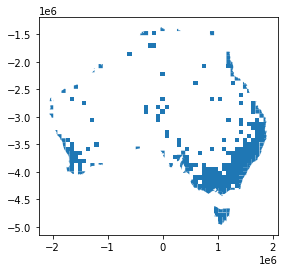

In [53]:
cells_geodf.loc[cell_counts.index.levels[cell_counts.index.names.index('cell_id')]].plot()

In [55]:
raw_cell_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('raw_cell_counts'), index=True)
cell_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('cell_counts'), index=True)

In [60]:
prior_mask = (~region_counts['is_proper']) & region_counts['nr_cell_mask']
cdf_mask = (region_counts.loc[prior_mask, 'count'] / region_counts.loc[prior_mask, 'count'].sum()).cumsum() < 0.99
mask = (cdf_mask & prior_mask).reindex(prior_mask.index)
word_vectors = word_counts.to_vectors(cell_counts, mask)
word_vectors = word_counts.vec_to_metric(word_vectors,
                                         region_counts.loc[mask],
                                         word_vec_var='polar')

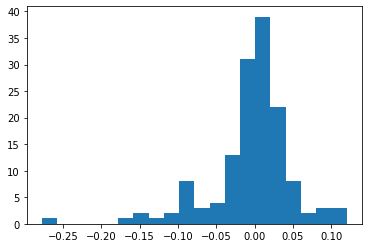

In [61]:
iloc_word = list(mask.loc[mask].index).index('have')
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(word_vectors[:, iloc_word], bins=20)

# Moran

In [468]:
relevant_cells = cell_counts.index.levels[cell_counts.index.names.index('cell_id')]
contiguity = libpysal.weights.Queen.from_dataframe(cells_geodf.loc[relevant_cells])
contiguity.transform = 'r'

In [469]:
num_cpus = 4
ray.init(num_cpus=num_cpus)
num_morans = word_vectors.shape[1]
shared_word_vectors = ray.put(word_vectors)
obj_refs = parallel.split_task(data_clustering.chunk_moran, num_cpus,
                               list(range(num_morans)), shared_word_vectors, contiguity)
res = ray.get(obj_refs)
moran_dict = res[0]
for m_dict in res[1:]:
    for key, value in m_dict.items():
        moran_dict[key].extend(value)

2021-02-26 15:27:45,352	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8266


In [413]:
region_counts = region_counts.join(pd.DataFrame.from_dict(moran_dict).set_index(region_counts.loc[prior_mask].loc[cdf_mask].index[:num_morans]))

In [503]:
region_counts.loc[(region_counts['p_value'] < 0.01) & (region_counts['z_value'] > 5)]

,count_upper,count,nr_cells,is_proper,nr_cell_mask,I,z_value,p_value
word,,,,,,,,
is,24125,437524,46,False,True,0.597490,6.261015,0.001
with,7623,227245,46,False,True,0.544524,5.616593,0.001
have,15796,190919,46,False,True,0.564684,5.917284,0.001
was,9365,186368,45,False,True,0.547882,5.671327,0.001
are,11073,180833,46,False,True,0.491163,5.135618,0.001
...,...,...,...,...,...,...,...,...
vocally,1,21,18,False,True,0.596515,6.514773,0.001
likeminded,0,21,21,False,True,0.439299,5.122707,0.002
moaners,1,21,23,False,True,0.456165,5.046692,0.001


In [506]:
region_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('region_counts'), index=True)